# QGPV gradients given mean velocity and buoyancy frequency profiles from cDrake

Profiles of mean geostrophic velocities from CPIES (they compare well with LADCP measurementes). From Teri:

"The basic structure is the same for LADCP and GEM-derived currents. See figure 12 in Yvonne Firing's JAOT paper for specifics.
http://dx.doi.org/10.1175/JTECH-D-13-00142.1 "

In [1]:
import numpy as np
from numpy import pi, cos, sin

import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
import scipy.integrate

from my_modes import *

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
/Users/crocha/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = np.load('fields2stability.npz')

lat = -58
beta = 2*7.29e-5*cos(lat*pi/180.)/6371.e3 
f0 = 2*7.29e-5*sin(lat*pi/180.)
i1 = 3
dec = 1
N2 = data['N2'][i1::dec]
U  = data['U'][i1::dec]
V  = data['V'][i1::dec]
z  = data['z'][i1::dec]
zp = (z[1:]+z[:-1])/2.


v, w = pmodes(N2,z,lat,nm=100)

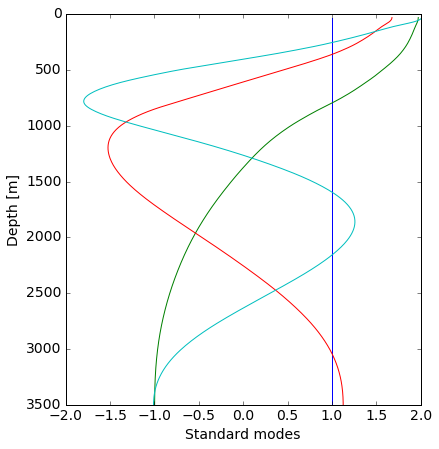

In [3]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)

ax1.plot(v[...,0],z)
ax1.plot(-v[...,1],z)
ax1.plot(v[...,2],z)
ax1.plot(v[...,3],z)


ax1.set_ylim(3500,0)
ax1.set_xlim(-2,2)

ax1.set_xlabel('Standard modes')
ax1.set_ylabel('Depth [m]')

In [46]:
def calc_QyQx(N2,z,U,V,lat):

    """ Calculates QGPV gradients """

    f0 = 2*7.29e-5*sin(lat*pi/180.)
    beta = 2*7.29e-5*cos(lat*pi/180.)/6371.e3 
    S = f0**2 / N2

    nz = S.size
    dz = abs(z[1]-z[0])
    dz2 = dz**2

    #  assemble strecthing matrix (standard staggered grid second order FD)
    SM = np.zeros((nz-1,nz-1))
    for i in range(nz-1):
        if i == 0:
            SM[0,0], SM[0,1] = -S[1]-2*S[0],S[1]
        elif i==nz-2:
            SM[-1,-2], SM[-1,-1] = S[-2], -S[-2]-2*S[-1]
        else:
            SM[i,i-1], SM[i,i], SM[i,i+1] = S[i], -(S[i+1]+S[i]), S[i+1]
    
    SM = SM/dz2

    # recall staggered stencil in the interior
    Up = (U[:-1]+U[1:])/2.
    Vp = (V[:-1]+V[1:])/2.
    zp = (z[:-1]+z[1:])/2.

    # calculate the base state PV gradients
    LU = np.einsum('ij,j->i',SM,Up) 
    LV = np.einsum('ij,j->i',SM,Vp)

    # this solves for the ghost point (involves U[0], but solves U[1/2]...)
    LU[0]  += 2*S[0]*U[0]/dz2
    LU[-1] += 2*S[-1]*U[-1]/dz2
    LV[0]  += 2*S[0]*V[0]/dz2
    LV[-1] += 2*S[-1]*V[-1]/dz2

    Qx = LV
    Qy = (beta-LU)

    return Qx, Qy

In [5]:
Qx,Qy = calc_QyQx(N2,-z,U,V,lat=lat)

In [51]:
def calc_QyQx_modal(w,Un,Vn,v,N,beta):
    LUg = -(np.einsum("i,ji->j",(w[:N+1]*Un),v[...,:N+1]))
    LVg = -(np.einsum("i,ji->j",(w[:N+1]*Vn),v[...,:N+1]))
    return LVg, (beta-LUg)

In [52]:
v2 = (v[1:]+v[:-1])/2.

In [8]:
Un,_, _ = project(v,U)
Vn,_, _ = project(v,V)

In [9]:
N = 1
Un1,Ug, errorUg = project(v[...,:N+1],U)
Vn1,Vg, errorVg = project(v[...,:N+1],V)
_,Qggx,_ = project(v2,Qx)
_,Qggy,_ = project(v2,Qy)

In [10]:
Qgx, Qgy = calc_QyQx_modal(w,Un1,Vn1,v,N,beta)

/Users/crocha/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


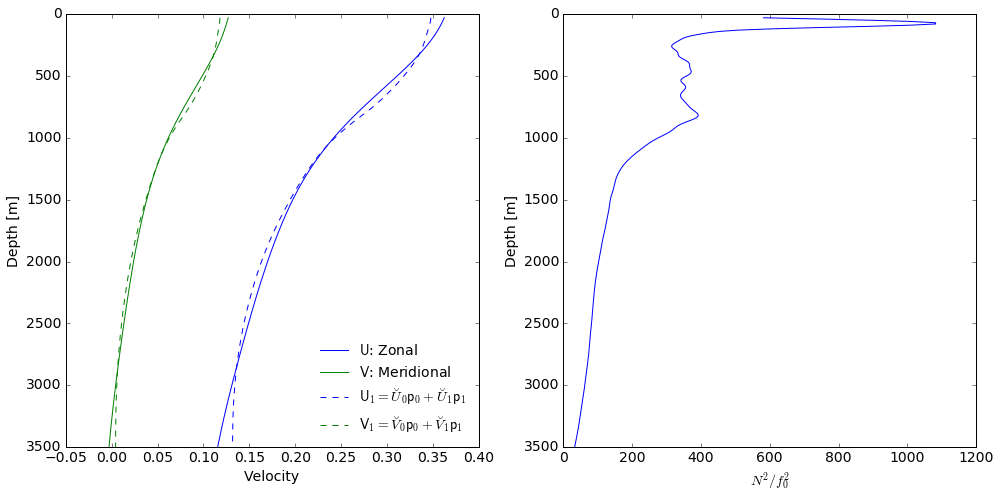

In [11]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)
ax1.plot(U,z,'b',label=r'$\mathsf{U}$: Zonal')
ax1.plot(V,z,'g',label=r'$\mathsf{V}$: Meridional')
ax1.plot(Ug,z,'b--',label=r'$\mathsf{U}_1 = \breve{U}_0 \mathsf{p}_0 + \breve{U}_1 \mathsf{p}_1$')
ax1.plot(Vg,z,'g--',label=r'$\mathsf{V}_1 = \breve{V}_0 \mathsf{p}_0 + \breve{V}_1 \mathsf{p}_1$')
ax1.set_ylim(3500,0)
ax1.set_xlabel('Velocity')
ax1.set_ylabel('Depth [m]')
ax1.legend(loc=4)


ax1 = fig.add_subplot(122)
ax1.plot(N2/np.abs(f0**2),z)
ax1.set_ylim(3500,0)
ax1.set_xlabel(r'$N^2/f_0^2$')
ax1.set_ylabel('Depth [m]')
ax1.legend(loc=4)

plt.tight_layout()


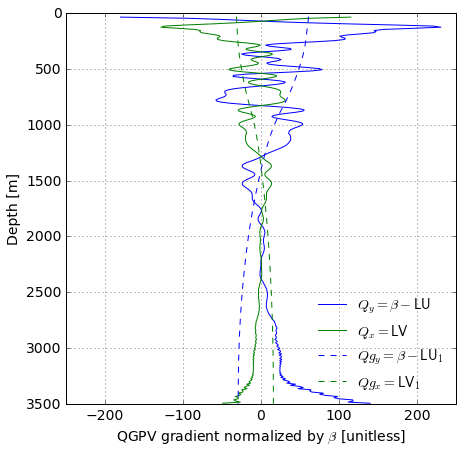

In [12]:
fig = plt.figure(figsize=(7,7))

ax1 = fig.add_subplot(111)

ax1.plot(Qy/beta,zp,'b',label=r'$Q_y = \beta - \mathsf{L}\mathsf{U}$')
ax1.plot(Qx/beta,zp,'g',label=r'$Q_x = \mathsf{L} \mathsf{V}$')
ax1.plot(Qgy.squeeze()/beta,z,'b--',label=r'$Qg_y = \beta - \mathsf{L}\mathsf{U_1}$')
ax1.plot(Qgx.squeeze()/beta,z,'g--',label=r'$Qg_x = \mathsf{L}\mathsf{V_1}$')
#ax1.plot(Qggy/beta,z,'b-+',label=r'$Qg_y = \beta - \mathsf{L}\mathsf{U_1}$')
#ax1.plot(Qggx/beta,z,'g-+',label=r'$Qg_y = \beta - \mathsf{L}\mathsf{U_1}$')



ax1.set_ylim(3500,0)
ax1.set_xlim(-250,250)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
ax1.legend(loc=4)
plt.grid()

In [13]:
Un2,Ug2, errorUg2 = project(v[...,:3],U)
Vn2,Vg2, errorVg2 = project(v[...,:3],V)
Qg2x,Qg2y = calc_QyQx(N2,-z,Ug2.squeeze(),Vg2.squeeze(),lat=lat)
Qg2x, Qg2y = calc_QyQx_modal(w,Un2,Vn2,v,2,beta)
_,Qgg2x,_ = project(v2[...,:2+1],Qx)
_,Qgg2y,_ = project(v2[...,:2+1],Qy)

Un3,Ug3, errorUg3 = project(v[...,:5],U)
Vn3,Vg3, errorVg3 = project(v[...,:5],V)
Qg3x, Qg3y = calc_QyQx_modal(w,Un3,Vn3,v,4,beta)
_,Qgg3x,_ = project(v2[...,:5],Qx)
_,Qgg3y,_ = project(v2[...,:5],Qy)

In [14]:
Un7,Ug7, errorUg7 = project(v[...,:8],U)
Vn7,Vg7, errorVg7 = project(v[...,:8],V)
Qg7x, Qg7y = calc_QyQx_modal(w,Un7,Vn7,v,7,beta)
_,Qgg7x,_ = project(v2[...,:7+1],Qx)
_,Qgg7y,_ = project(v2[...,:7+1],Qy)


Un25,Ug25, errorUg25 = project(v[...,:26],U)
Vn25,Vg25, errorVg25 = project(v[...,:26],V)
Qg25x, Qg25y = calc_QyQx_modal(w,Un25,Vn25,v,25,beta)
_,Qgg25x,_ = project(v2[...,:26],Qx)
_,Qgg25y,_ = project(v2[...,:26],Qy)

Un100,Ug100, errorUg100 = project(v[...,:100],U)
Vn100,Vg100, errorVg100 = project(v[...,:100],V)
Qg100x, Qg100y = calc_QyQx_modal(w,Un100,Vn100,v,99,beta)
_,Qgg100x,_ = project(v2[...,:100],Qx)
_,Qgg100y,_ = project(v2[...,:100],Qy)

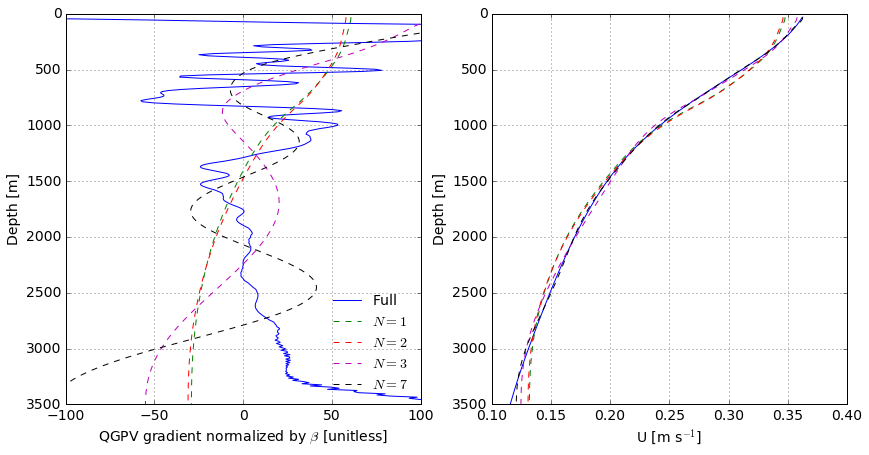

In [15]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.plot(Qy/beta,zp,label=r'Full')
ax1.plot(Qgy/beta,z,'--',label=r'$N=1$')
ax1.plot(Qg2y/beta,z,'--',label=r'$N=2$')
#ax1.plot(Qgg2y/beta,z,'-+',label=r'$N=2$')
ax1.plot(Qg3y/beta,z,'m--',label=r'$N=3$')
#ax1.plot(Qgg3y/beta,z,'m-+',label=r'$N=3$')
ax1.plot(Qg7y/beta,z,'k--',label=r'$N=7$')
#ax1.plot(Qgg7y/beta,z,'k-+',label=r'$N=7$')
#ax1.plot(Qg25y/beta,z,'y--',label=r'$N=25$')


ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
ax1.legend(loc=4,)
plt.grid()

ax1 = fig.add_subplot(122)
ax1.plot(U,z,'-',label='Full')
ax1.plot(Ug,z,'--',label=r'$N=1$')
ax1.plot(Ug2,z,'--',label=r'$N=1$')
ax1.plot(Ug3,z,'m--',label=r'$N=3$')
ax1.plot(Ug7,z,'k--',label=r'$N=7$')
#ax1.plot(Ug25,z,'y--',label=r'$N=25$')




ax1.set_ylim(3500,0)
ax1.set_xlim(.1,.4)
ax1.set_xlabel(r'U [m s$^{-1}$]')
ax1.set_ylabel('Depth [m]')
plt.grid()

In [16]:
np.array([errorUg,errorUg2,errorUg3])/U.std()

array([ 0.0918168 ,  0.09079736,  0.0414633 ])

# Compare term-by-term differatiation with projection of Qx and Qy
The results are indistinguishable with N=1 and N=2, but wildly different with N>=3. Below, the solid lines represent the Qy obtained by term-by-term differentiating the series U and the dashed lines represent Qy calculated by projecting the finite-difference approximation of (beta - LU) onto N baroclinic modes. Blue solid line is Qy calculated by finite-difference approx. of (beta-LU).

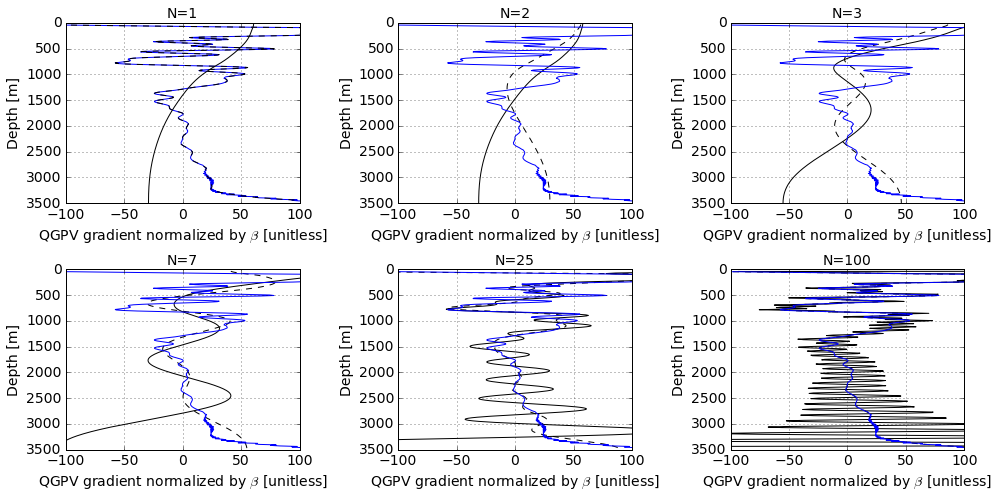

In [17]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(231)
ax1.plot(Qy/beta,zp,'b',linewidth=1.)

ax1.plot(Qgy/beta,z,'k-',label=r'$N=1$')
ax1.plot(Qggy/beta,zp,'k--')

ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=1')


ax1 = fig.add_subplot(232)

ax1.plot(Qg2y/beta,z,'k-',label=r'$N=2$')
ax1.plot(Qgg2y/beta,zp,'k--')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=2')


ax1 = fig.add_subplot(233)
ax1.plot(Qg3y/beta,z,'k-',label=r'$N=3$')
ax1.plot(Qgg3y/beta,zp,'k--')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=3')


ax1 = fig.add_subplot(234)
ax1.plot(Qg7y/beta,z,'k-',label=r'$N=7$')
ax1.plot(Qgg7y/beta,zp,'k--')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=7')


ax1 = fig.add_subplot(235)
ax1.plot(Qg25y/beta,z,'k-',label=r'$N=25$')
ax1.plot(Qgg25y/beta,zp,'k--')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=25')


ax1 = fig.add_subplot(236)
ax1.plot(Qg100y/beta,z,'k-',label=r'$N=25$')
ax1.plot(Qgg100y/beta,zp,'k--')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=100')

plt.tight_layout()






# Now repeat the calculations decomposing the velocity
The strong shear near the "bottom" precudes an accurate estimation of the PV gradients based differention of the Galerkin series for U and V. To overcome this difficulty, we decompose the velocity field

$$ U = U_s(z) + U_i(z)$$

$$ V = V_s(z) + V_i(z)$$

where $U_i$ and $V_i$ is a satisfiy homogeneous Neumann boundary conditions, and $U_s$ and $V_s$ contains the satisfy inhomogeneous boundary conditions: $U_s'(0)=U'(0)$, etc.


In [35]:

def decomp_vel(z,N2,U,f2 = 1.e-2):
    h = z[-1]-z[0]
    h2 = h**2
    dz = z[1]-z[0]
    Up0 = (U[0]-U[1])/dz
    Uph = (U[-2]-U[-1])/dz
    zs = -z+z[0]
    I1,I2 = np.empty_like(z), np.empty_like(z)
    Us = np.empty_like(z)
    N2s = N2
    for i in range(I1.size):
        I1[i] = sp.integrate.simps(N2s[:i+1]*(zs[:i+1]+h),zs[:i+1])
        I2[i] = sp.integrate.simps(N2s[:i+1]*zs[:i+1],zs[:i+1])

    A = -sp.integrate.simps(-I1*Up0/N2s[0]/h2 + I2*Uph/N2s[-1]/h2,zs)

    Us = I1*Up0/N2s[0]/h -I2*Uph/N2s[-1]/h + A

    Up = U - Us
    
    LUs = (f2/N2s[0])*Up0/h - (f2/N2s[-1])*Uph/h
    
    return Us,Up, LUs

Us, Up, LUs = decomp_vel(z,N2,U,f2=f0**2)
Vs, Vp, LVs = decomp_vel(z,N2,V,f2=f0**2)

(-0.15, 0.45)

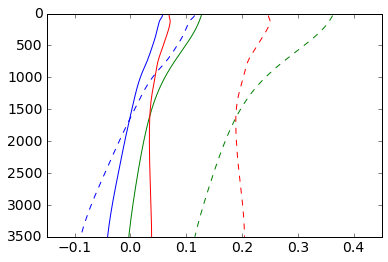

In [36]:
plt.plot(Vs,z)
plt.plot(V,z)
plt.plot(Vp,z)
plt.plot(Us,z,'b--')
plt.plot(U,z,'g--')
plt.plot(Up,z,'r--')
plt.ylim(3500,0)
plt.xlim(-.15,.45)

In [48]:
Un,Ug, errorUg = project(v[...,:2],Up)
Vn,Vg, errorVg = project(v[...,:2],Vp)
Qgx, Qgy = calc_QyQx_modal(w,Un,Vn,v,1,beta)
Qgx += LVs
Qgy -= LUs

Un2,Ug2, errorUg2 = project(v[...,:3],Up)
Vn2,Vg2, errorVg2 = project(v[...,:3],Vp)
Qg2x, Qg2y = calc_QyQx_modal(w,Un2,Vn2,v,2,beta)

Qg2x += LVs
Qg2y -= LUs

Un3,Ug3, errorUg4 = project(v[...,:5],Up)
Vn3,Vg3, errorVg4 = project(v[...,:5],Vp)
Qg3x, Qg3y = calc_QyQx_modal(w,Un3,Vn3,v,4,beta)
Qg3x += LVs
Qg3y -= LUs

Un7,Ug7, errorUg7 = project(v[...,:8],Up)
Vn7,Vg7, errorVg7 = project(v[...,:8],Vp)
Qg7x, Qg7y = calc_QyQx_modal(w,Un7,Vn7,v,7,beta)
Qg7x += LVs
Qg7y -= LUs

Un25,Ug25, errorUg25 = project(v[...,:26],Up)
Vn25,Vg25, errorVg25 = project(v[...,:26],Vp)
Qg25x, Qg25y = calc_QyQx_modal(w,Un25,Vn25,v,25,beta)
Qg25x += LVs
Qg25y -= LUs

Un100,Ug100, errorUg100 = project(v[...,:101],Up)
Vn100,Vg100, errorVg100 = project(v[...,:101],Vp)
Qg100x, Qg100y = calc_QyQx_modal(w,Un100,Vn100,v,100,beta)

Qg100x += LVs
Qg100y -= LUs

In [49]:
Qgy.shape, zp.size

((347,), 346)

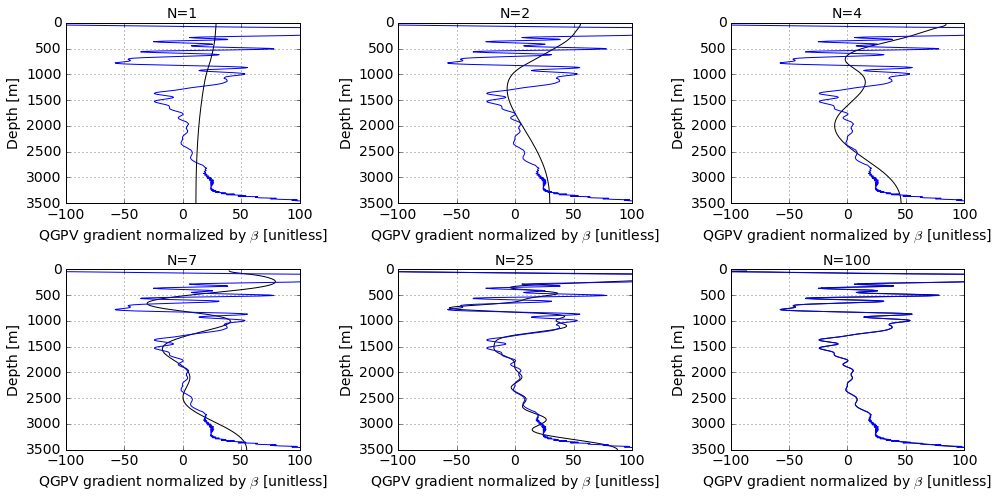

In [50]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(231)
ax1.plot(Qy/beta,zp,'b',linewidth=1.)

ax1.plot(Qgy/beta,z,'k-',label=r'$N=1$')

ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=1')


ax1 = fig.add_subplot(232)

ax1.plot(Qg2y/beta,z,'k-',label=r'$N=2$')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=2')

ax1 = fig.add_subplot(233)

ax1.plot(Qg3y/beta,z,'k-',label=r'$N=4$')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=4')

ax1 = fig.add_subplot(234)

ax1.plot(Qg7y/beta,z,'k-',label=r'$N=7$')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=7')

ax1 = fig.add_subplot(235)

ax1.plot(Qg25y/beta,z,'k-',label=r'$N=25$')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=25')

ax1 = fig.add_subplot(236)

ax1.plot(Qg100y/beta,z,'k-',label=r'$N=100$')
ax1.plot(Qy/beta,zp,'b',linewidth=1.)
ax1.set_ylim(3500,0)
ax1.set_xlim(-100,100)
ax1.set_xlabel(r'QGPV gradient normalized by $\beta$ [unitless]')
ax1.set_ylabel('Depth [m]')
plt.grid()
plt.title('N=100')
plt.tight_layout()

